# 2019 MLB Hitting dataset cleaning and analysis

#### Datasource:
- [2019 and 2020 Hitting Data]('https://www.rotowire.com/baseball/stats.php')

#### Todo List:
- Imports
- Clean the data if need be
- Vizualize some of the data
- Start building models
- Tune Models
- Find the Top 2 best models for the data sets
- Create Easy to Read Dataframes comparing the test data and the predictions


#### Goal:

My Goal for this part of the project is to be able to predict batting average for each player with around 85-90% accuracy. I also want to take the time to explore the data and get a good understanding of it.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#Model Building Imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

#Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Read in dataset
df = pd.read_csv('2019-batting-players.csv', index_col='Player')

In [3]:
# looking at the first 5 rows of data
df.head(5)

,Team,Pos,Age,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,SH,SF,HBP,AVG,OBP,SLG,OPS
Player,,,,,,,,,,,,,,,,,,,,,,
Whit Merrifield,KC,2B,31,162,681,105,206,41,10,16,74,20,10,45,126,0,4,5,0.302,0.348,0.463,0.811
Marcus Semien,OAK,SS,29,162,657,123,187,43,7,33,92,10,8,87,102,0,1,2,0.285,0.369,0.522,0.891
Rafael Devers,BOS,3B,23,156,647,129,201,54,4,32,115,8,8,48,119,1,2,4,0.311,0.361,0.555,0.916
Jonathan Villar,BAL,2B,29,162,642,111,176,33,5,24,73,40,9,61,176,2,4,4,0.274,0.339,0.453,0.792
Ozzie Albies,ATL,2B,23,160,640,102,189,43,8,24,86,15,4,54,112,0,4,4,0.295,0.352,0.500,0.852


In [4]:
df = df.drop('Team', axis=1)

In [5]:
# Describing the dataset
print(round(df.describe()))

         Age      G     AB      R      H  ...    HBP    AVG    OBP    SLG    OPS
count  694.0  694.0  694.0  694.0  694.0  ...  694.0  694.0  694.0  694.0  694.0
mean    29.0   72.0  234.0   33.0   60.0  ...    3.0    0.0    0.0    0.0    1.0
std      4.0   51.0  191.0   31.0   54.0  ...    4.0    0.0    0.0    0.0    0.0
min     21.0    1.0    1.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0
25%     26.0   25.0   56.0    6.0   12.0  ...    0.0    0.0    0.0    0.0    1.0
50%     28.0   69.0  191.0   26.0   44.0  ...    2.0    0.0    0.0    0.0    1.0
75%     31.0  120.0  392.0   54.0  100.0  ...    4.0    0.0    0.0    0.0    1.0
max     46.0  162.0  681.0  135.0  206.0  ...   27.0    0.0    1.0    1.0    1.0

[8 rows x 20 columns]


In [6]:
# Getting count of missing values
missing_value_count = df.isnull().sum()

# Getting missing values for all columns
missing_value_count[:len(df.columns)]

Pos    0
Age    0
G      0
AB     0
R      0
H      0
2B     0
3B     0
HR     0
RBI    0
SB     0
CS     0
BB     0
SO     0
SH     0
SF     0
HBP    0
AVG    0
OBP    0
SLG    0
OPS    0
dtype: int64

### There are no missing values in this dataset

#### Column Labels
- Tm: Team Name
- BatAge: Average Player Age for Each Team
- R/G: Runs per Game
- G: Games played
- PA: Number of Plate Appearances
- AB: Number of At Bats
- R: Number of Runs scored
- H: Number of Hits
- 2B: Number of Doubles
- 3B: Number of Triples
- HR: Numbber of Homeruns
- RBI: Number of Runs Batted In

In [7]:
# Visualization Functions
def create_distplot(df, column):
  plt.figure(figsize=(10,5))
  plt.title(f"Displot: {column}")
  sns.distplot(df[column], hist=True, color="g", kde_kws={"shade": True})

def create_scatter(df, x, y):
  plt.figure(figsize=(10,5))
  plt.title(f"Scatter: {x} vs {y}")
  sns.scatterplot(df[x], df[y])

def create_heatmap(df):
  corr = df.corr()
  plt.figure(figsize=(16,8))
  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})
  
def create_lineplot(df, x, y, hue=None, style=None):
  plt.figure(figsize=(16,8))
  plt.title(f"Lineplot: {x} vs {y}")
  sns.lineplot(x=x, y=y,
               hue = hue,
               style=style,
               data=df)

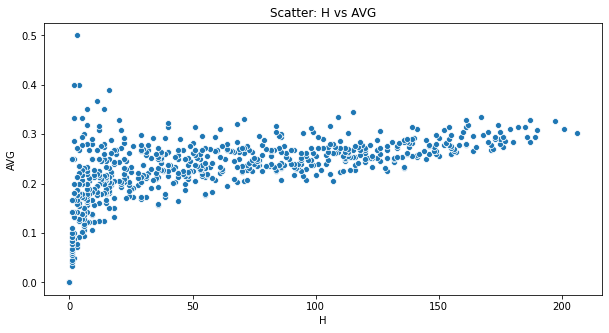

In [8]:
# Scatter for Hits vs Batting Average
create_scatter(df, 'H', 'AVG')

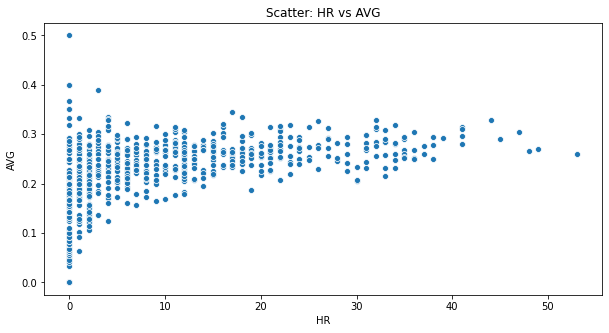

In [9]:
# Scatter for Homeruns vs Batting Average
create_scatter(df, 'HR', 'AVG')

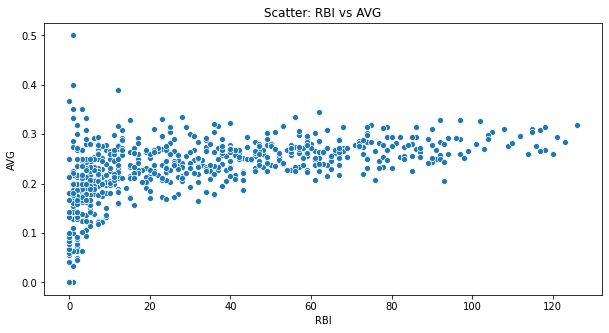

In [10]:
#Scatter for Runs Batted In vs Batting Average
create_scatter(df, 'RBI', 'AVG')

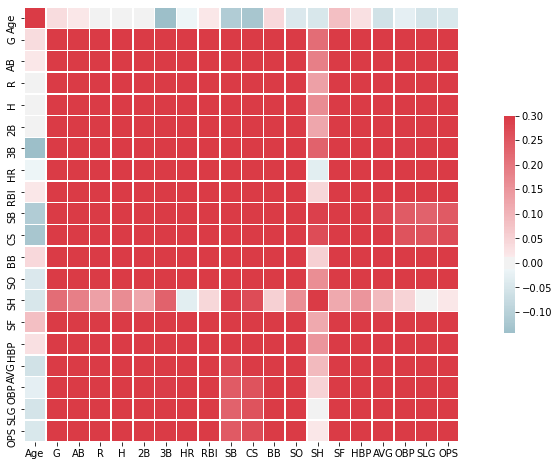

In [11]:
#Heatmap for data
create_heatmap(df)

In [12]:
# Getting all cont features in one list
cont_features = df[['Age',
 'G',
 'AB',
 'R',
 'H',
 '2B',
 '3B',
 'HR',
 'RBI',
 'SB',
 'CS',
 'BB',
 'SO',
 'SH',
 'SF',
 'HBP',
 'AVG',
 'OBP',
 'SLG',
 'OPS']]

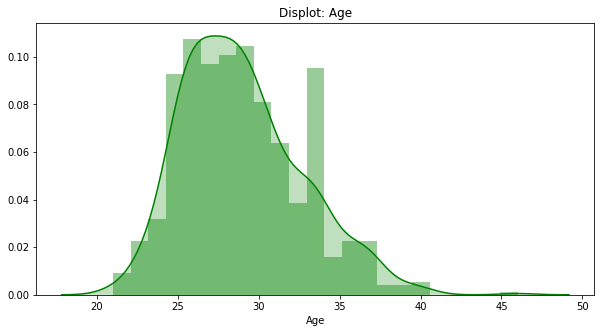

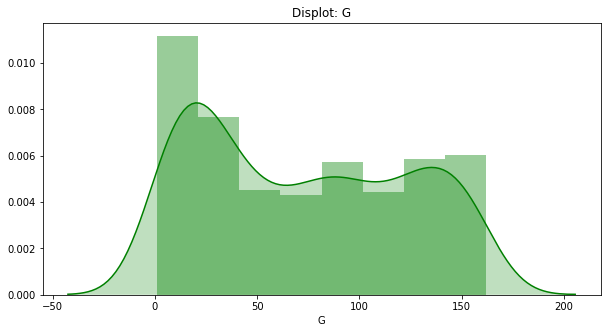

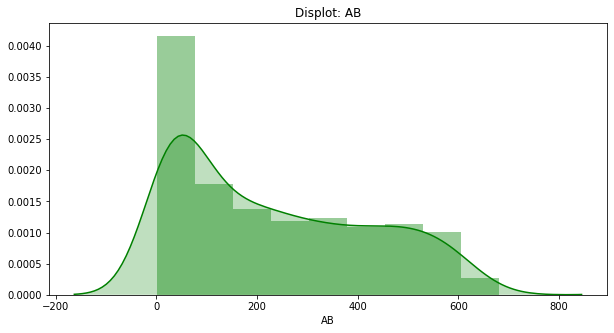

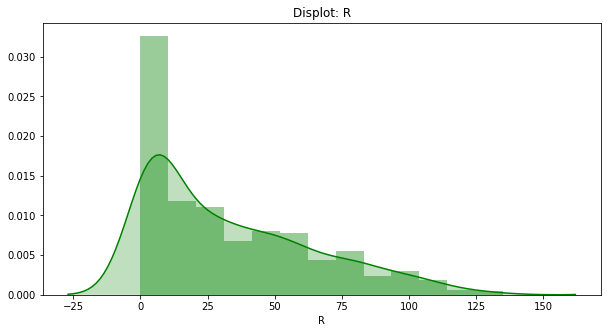

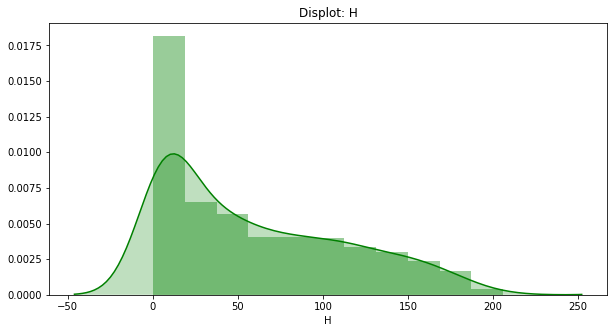

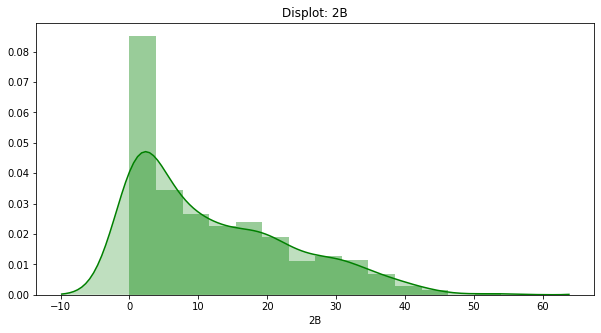

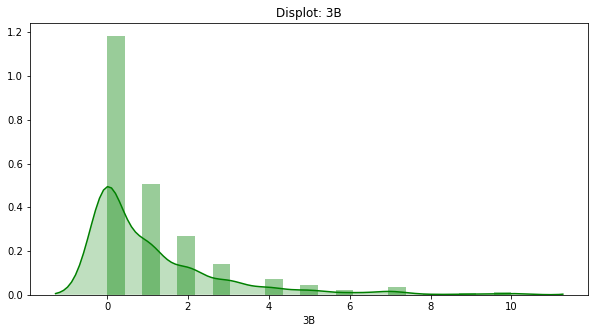

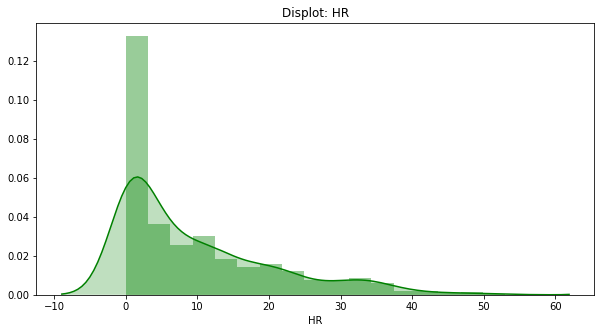

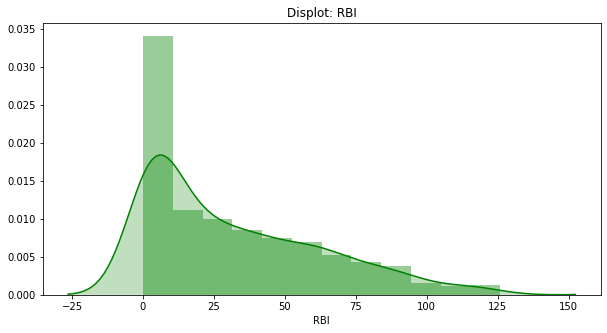

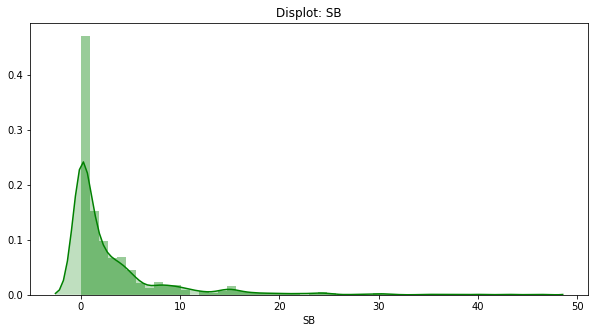

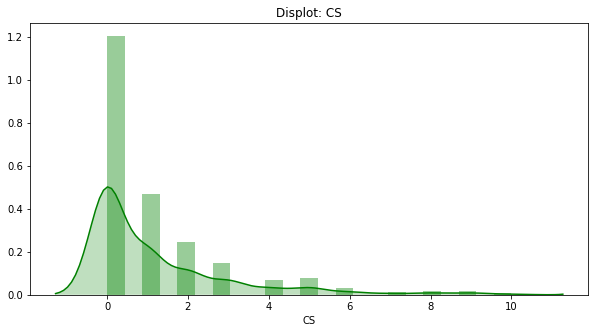

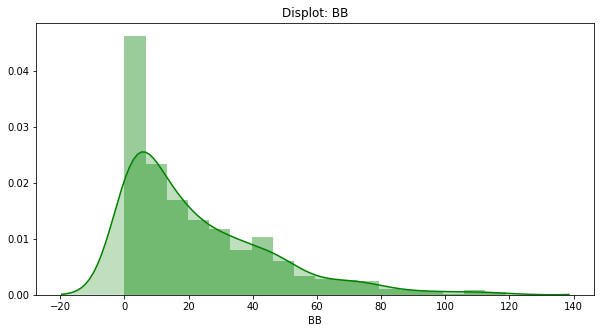

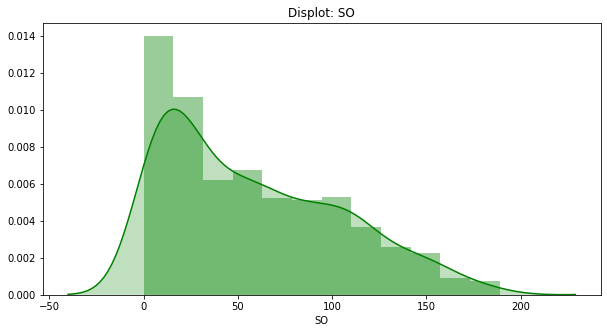

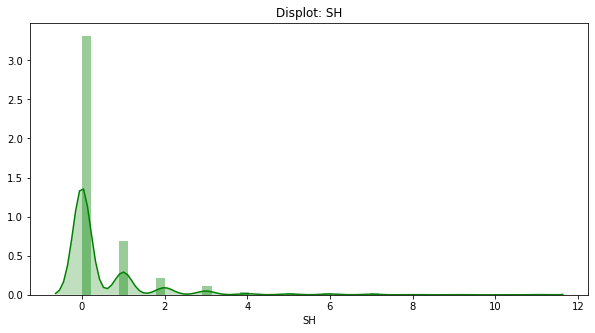

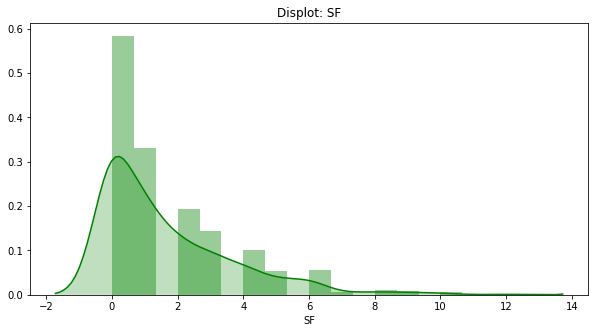

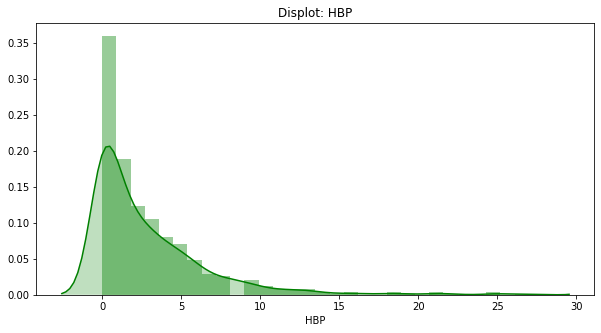

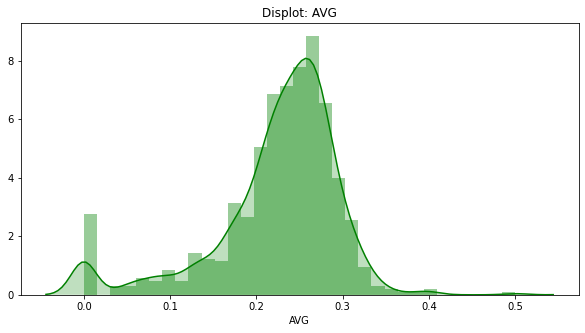

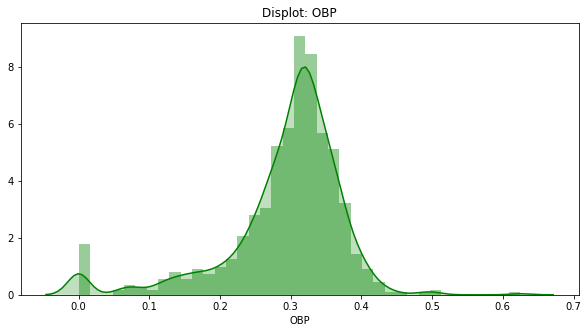

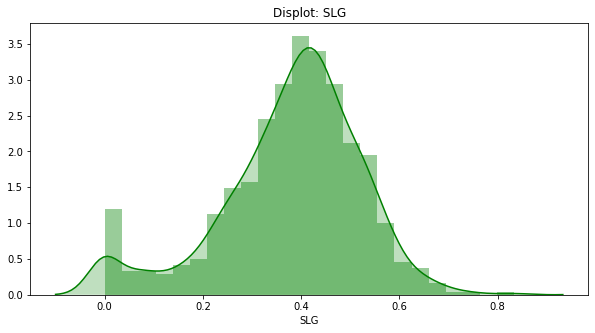

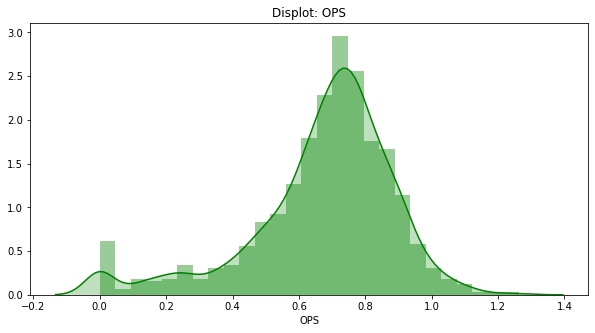

In [13]:
# making dist plots for all cont features
for feature in cont_features:
  create_distplot(df, feature)

In [14]:
df_corr = df.corr()
df_corr

,Age,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,SH,SF,HBP,AVG,OBP,SLG,OPS
Age,1.000000,0.038070,0.016136,-0.010009,0.006317,-0.000689,-0.143433,-0.012528,0.018767,-0.110743,-0.127840,0.040966,-0.041368,-0.046867,0.082395,0.029142,-0.059650,-0.025679,-0.054268,-0.045652
G,0.038070,1.000000,0.969954,0.915875,0.942287,0.896391,0.564664,0.806315,0.895450,0.488312,0.550636,0.837751,0.898666,0.215864,0.672713,0.607395,0.528612,0.503941,0.535616,0.546692
AB,0.016136,0.969954,1.000000,0.957838,0.986074,0.939468,0.602716,0.848267,0.937138,0.521678,0.579466,0.848547,0.904599,0.184299,0.705769,0.602817,0.521537,0.482275,0.534844,0.537869
R,-0.010009,0.915875,0.957838,1.000000,0.965904,0.933810,0.599291,0.903566,0.945905,0.540560,0.567191,0.884751,0.868967,0.133138,0.673317,0.616215,0.526657,0.511992,0.582472,0.580691
H,0.006317,0.942287,0.986074,0.965904,1.000000,0.952104,0.617674,0.847494,0.939549,0.528482,0.580298,0.825302,0.858383,0.164642,0.705616,0.586628,0.563677,0.507328,0.563493,0.566382
2B,-0.000689,0.896391,0.939468,0.933810,0.952104,1.000000,0.583682,0.806385,0.906077,0.489094,0.553691,0.797705,0.822149,0.122763,0.683754,0.565040,0.540306,0.488869,0.563757,0.559473
3B,-0.143433,0.564664,0.602716,0.599291,0.617674,0.583682,1.000000,0.415981,0.512286,0.607391,0.598862,0.450018,0.523927,0.231963,0.433295,0.345210,0.341491,0.293806,0.326447,0.328080
HR,-0.012528,0.806315,0.848267,0.903566,0.847494,0.806385,0.415981,1.000000,0.943098,0.343939,0.386752,0.840008,0.840046,-0.031770,0.603809,0.569077,0.447735,0.453961,0.617281,0.581389
RBI,0.018767,0.895450,0.937138,0.945905,0.939549,0.906077,0.512286,0.943098,1.000000,0.410716,0.462227,0.853445,0.863211,0.043620,0.719915,0.584599,0.511626,0.488010,0.602898,0.584964
SB,-0.110743,0.488312,0.521678,0.540560,0.528482,0.489094,0.607391,0.343939,0.410716,1.000000,0.736842,0.401326,0.475337,0.288812,0.322329,0.330922,0.279363,0.244480,0.233177,0.247626


In [15]:
# Getting Features that have a correlation of greater than 0.5 for model building
selected_features = []
for i in range(len(df_corr['AVG'])):
  if df_corr['AVG'].values[i] >= 0.5 and df_corr['AVG'].values[i] != 1.0:
    selected_features.append(df_corr['AVG'].index[i])

In [16]:
selected_features

['G', 'AB', 'R', 'H', '2B', 'RBI', 'OBP', 'SLG', 'OPS']

#### Model Building

- Lasso
- Linear Regression
- Ridge
- Elastic Net
- RandomForest

In [17]:
# Splitting Data into train and test
X = df[selected_features]
y = df['AVG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [18]:
#Function to test different Models
def test_model(model_to_test, X_test, X_train, y_test, y_train):
    f_steps = [
                ('model', model_to_test)
      ]

    f_pipe = Pipeline(steps=f_steps)
    f_pipe.fit(X_train, y_train)

    f_preds = f_pipe.predict(X_test)
    print("-" * 10 + " Model Stats " + "-" * 10)
    print('\n')
    print(f"Model Score: {f_pipe.score(X_test, y_test)}")
    print(f"MAE: {mean_absolute_error(y_test, f_preds)}")
    print(f"MSE: {mean_squared_error(y_test, f_preds)}")
    print('\n')
    print('-' * 80)
    print('\n')
    plt.figure(figsize=(10,5))
    plt.title("Model Predictions")
    plt.scatter(y_test.index[:20], y_test.values[:20])
    plt.scatter(y_test.index[:20], f_preds[:20])
    plt.xticks(rotation=90)
    plt.legend(['Test Data', 'Predictions'])

    return f_pipe

---------- Model Stats ----------


Model Score: 0.886452534114476
MAE: 0.015658602713191413
MSE: 0.0005497994240891512


--------------------------------------------------------------------------------




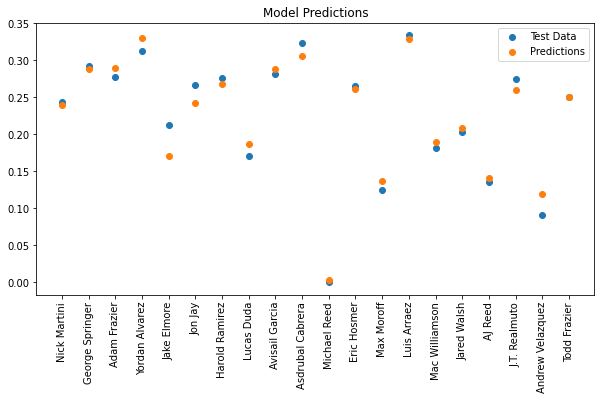

In [19]:
#LinearRegression
lr_model = test_model(LinearRegression(), X_test, X_train, y_test, y_train)

---------- Model Stats ----------


Model Score: 0.8525501399138317
MAE: 0.01923013875598085
MSE: 0.000713955591392344


--------------------------------------------------------------------------------




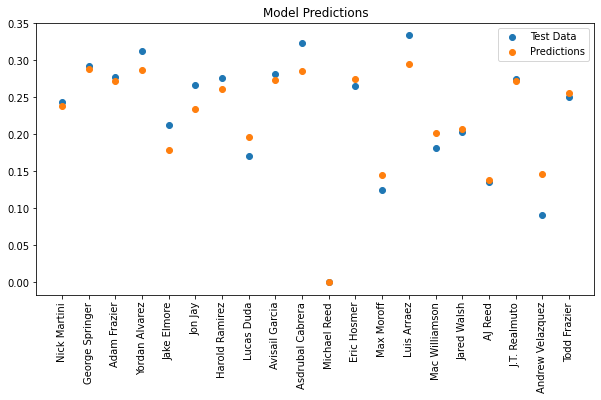

In [20]:
rf_model = test_model(RandomForestRegressor(), X_test, X_train, y_test, y_train)

---------- Model Stats ----------


Model Score: 0.20425572582063056
MAE: 0.04369577495857756
MSE: 0.0038530119563137976


--------------------------------------------------------------------------------




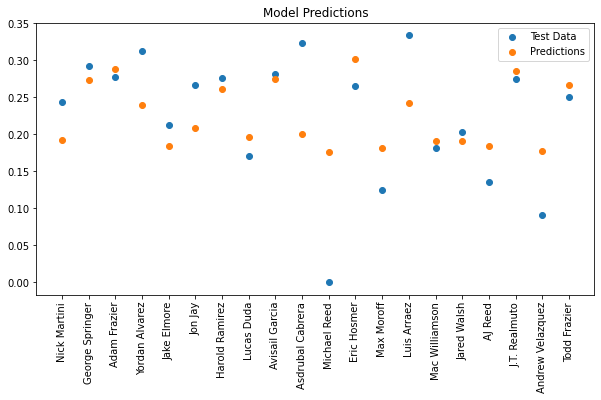

In [21]:
#Lasso Model
lasso_model = test_model(Lasso(alpha=0.3), X_test, X_train, y_test, y_train)

---------- Model Stats ----------


Model Score: 0.8789261220052803
MAE: 0.016019260875801977
MSE: 0.0005862424834812935


--------------------------------------------------------------------------------




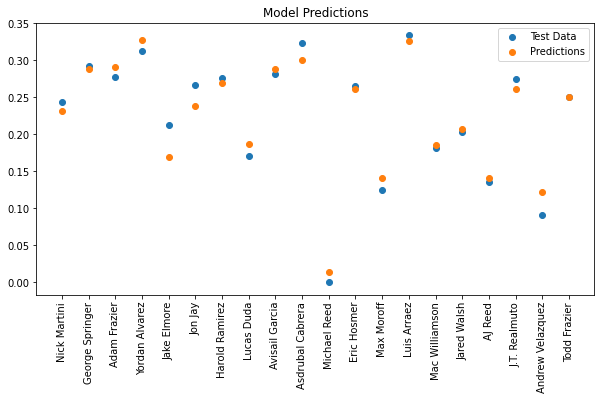

In [22]:
#Ridge Model
ridge_model = test_model(Ridge(alpha=0.7), X_test, X_train, y_test, y_train)

---------- Model Stats ----------


Model Score: 0.20699595156906925
MAE: 0.04356292839964111
MSE: 0.003839743720632653


--------------------------------------------------------------------------------




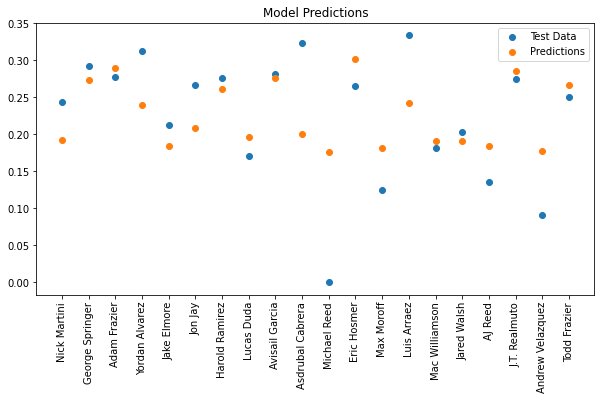

In [23]:
#ElasticNet Model
elastic_model = test_model(ElasticNet(alpha=0.5), X_test, X_train, y_test, y_train)

In [24]:
# Bring in 2020 Data
df_2020 = pd.read_csv('2020-batting-players.csv', index_col='Player')

In [25]:
#Split out data into X and y
X_2020 = df_2020[selected_features]
y_2020 = df_2020['AVG']

In [26]:
# Make predictions
y_preds = lr_model.predict(X_2020)

In [27]:
# Score the Model
lr_model.score(X_2020, y_2020)

0.8555965407916791

In [28]:
def score_new_dataset(model, X, y):
  # Make predictions
  f_preds = model.predict(X)

  # Score the Model
  f_score = model.score(X, y)

  #Print out findings
  print("Model Metrics")
  print("-" * 50)
  print('\n')
  print(f"Model Score: {f_score}")
  print(f"MAE: {mean_absolute_error(y, f_preds)}")
  print(f"MSE: {mean_squared_error(y, y_preds)}")

  # Graph Predictions
  print('\n')
  print('-' * 80)
  print('\n')
  plt.figure(figsize=(10,5))
  plt.title("First 10 Model Predictions")
  plt.scatter(y.index[:10], y.values[:10])
  plt.scatter(y.index[:10], f_preds[:10])
  plt.xticks(rotation=45)
  plt.legend(['Test Data', 'Predictions'])

  #Return predictions
  return f_preds



Model Metrics
--------------------------------------------------


Model Score: 0.8555965407916791
MAE: 0.031155406388594473
MSE: 0.0020354435152200256


--------------------------------------------------------------------------------




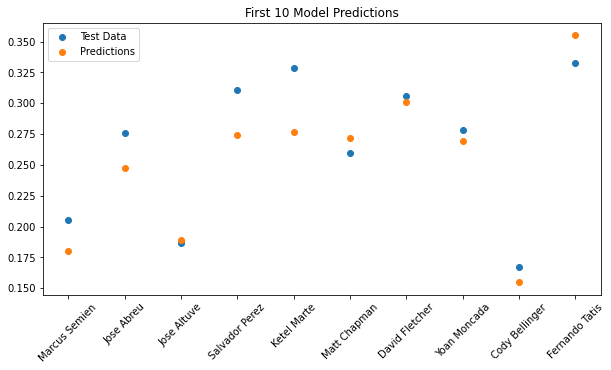

In [29]:
#LinearRegression Scoring on 2020 Data
lr_preds = score_new_dataset(lr_model, X_2020, y_2020)

Model Metrics
--------------------------------------------------


Model Score: 0.6926765126379384
MAE: 0.033104652631578954
MSE: 0.0020354435152200256


--------------------------------------------------------------------------------




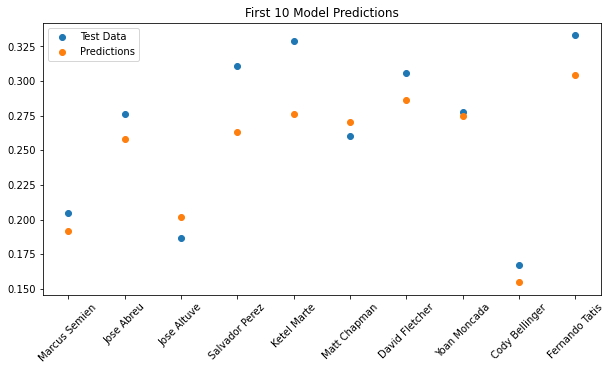

In [30]:
#RandomForest Scoring on 2020 Data
rf_preds = score_new_dataset(rf_model, X_2020, y_2020)

Model Metrics
--------------------------------------------------


Model Score: 0.841258430420035
MAE: 0.03224717909893955
MSE: 0.0020354435152200256


--------------------------------------------------------------------------------




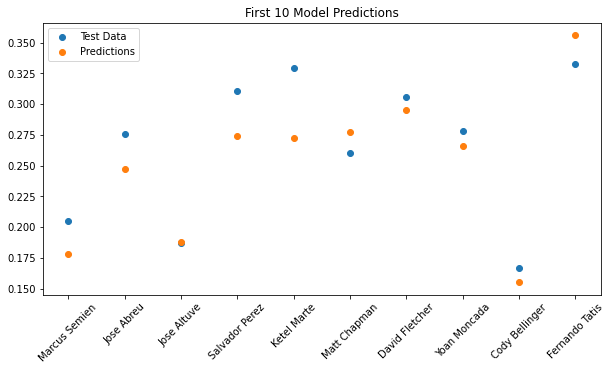

In [31]:
#RidgeRegression Scoring on 2020 Data
ridge_preds = score_new_dataset(ridge_model, X_2020, y_2020)

Model Metrics
--------------------------------------------------


Model Score: -0.08828794888693459
MAE: 0.08698710250231577
MSE: 0.0020354435152200256


--------------------------------------------------------------------------------




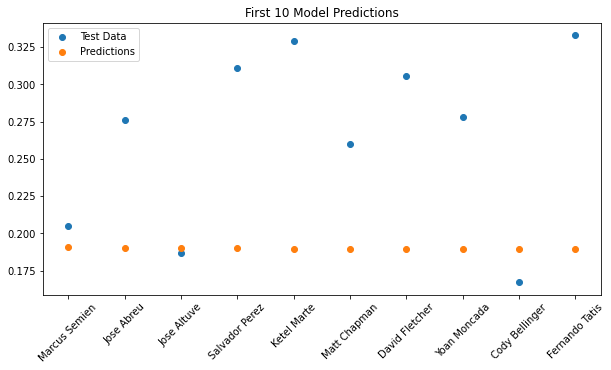

In [32]:
#LassoRegression Scoring on 2020 Data
lasso_preds = score_new_dataset(lasso_model, X_2020, y_2020)

Model Metrics
--------------------------------------------------


Model Score: -0.0878806697438792
MAE: 0.08696857989754836
MSE: 0.0020354435152200256


--------------------------------------------------------------------------------




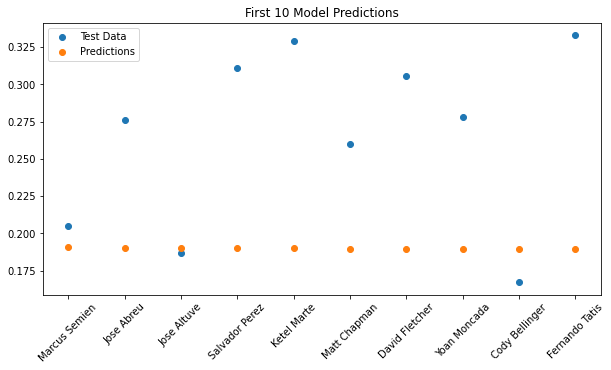

In [33]:
#ElasticNetRegression Scoring on 2020 Data
elastic_preds = score_new_dataset(elastic_model, X_2020, y_2020)

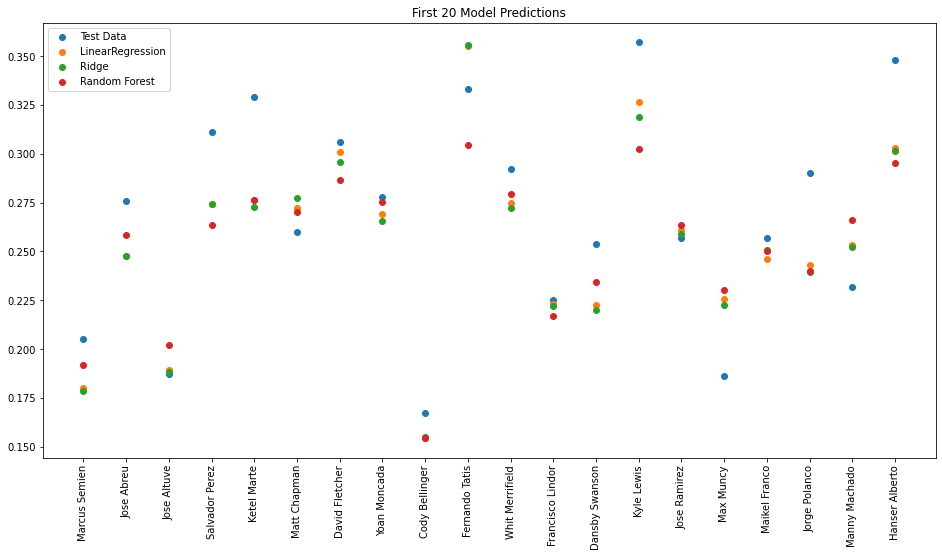

In [34]:
# Comparing All Models Top 20 Predictions
plt.figure(figsize=(16,8))
plt.title("First 20 Model Predictions")
plt.scatter(y_2020.index[:20], y_2020.values[:20])
plt.scatter(y_2020.index[:20], lr_preds[:20])
plt.scatter(y_2020.index[:20], ridge_preds[:20])
plt.scatter(y_2020.index[:20], rf_preds[:20])
plt.xticks(rotation=90)
plt.legend(['Test Data', 'LinearRegression', 'Ridge', 'Random Forest'], loc='upper left')

In [35]:
# LinearRegression Predictions
lr_predictions_df = pd.DataFrame({'Test Data': y_2020, 'LR Predictions':lr_preds})

In [36]:
# Lets see the lr_predictions_df 
lr_predictions_df.head()

,Test Data,LR Predictions
Player,,
Marcus Semien,0.205,0.179911
Jose Abreu,0.276,0.247535
Jose Altuve,0.187,0.189176
Salvador Perez,0.311,0.274311
Ketel Marte,0.329,0.276391


In [37]:
# RidgeRegression Predictions
ridge_predictions_df = pd.DataFrame({'Test Data': y_2020, 'Ridge Predictions':ridge_preds})

In [38]:
# Lets see the ridge_regression_df
ridge_predictions_df.head()

,Test Data,Ridge Predictions
Player,,
Marcus Semien,0.205,0.178495
Jose Abreu,0.276,0.247483
Jose Altuve,0.187,0.187987
Salvador Perez,0.311,0.274020
Ketel Marte,0.329,0.272489


In [40]:
# Exporting Model for later use
import pickle

filename_ridge = 'ridge_hitting_model.sav'
pickle.dump(ridge_model, open(filename_ridge, 'wb'))

filename_lr = 'lr_hitting_model.sav'
pickle.dump(lr_model, open(filename_lr, 'wb'))